# \<center\>Applying ICA to HD 12484

In [1]:
# Before anything, import relevant modules
%load_ext autoreload
%autoreload 2
import autograd.numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
sys.path.append(os.getcwd()+'/ICA') # to use personal ICA package
from utils import SNR, standardize, plot_2D_distrib, mean, whiten
from core import CustomICA, PostProcess
from heuristics import sk_FastICA, jadeR, V_manifold_optim, A_manifold_const, FOBI, partial_FastICA, PCA
from scipy.optimize import minimize

## Data pre-processing

In [2]:
planet = 'HD12484'
period = 58.83

In [3]:
os.listdir('data/'+planet)

['.DS_Store',
 'Log_HD12484.dat',
 'SOPHIE.2012-09-17T04_07_44.417_ccf_G2_A.tbl',
 'SOPHIE.2012-09-18T01_30_53.915_ccf_G2_A.tbl',
 'SOPHIE.2012-09-21T02_31_27.003_ccf_G2_A.tbl',
 'SOPHIE.2012-10-23T23_08_11.803_ccf_G2_A.tbl',
 'SOPHIE.2012-11-07T00_37_52.990_ccf_G2_A.tbl',
 'SOPHIE.2012-11-19T22_25_40.811_ccf_G2_A.tbl',
 'SOPHIE.2012-11-30T21_45_39.472_ccf_G2_A.tbl',
 'SOPHIE.2013-01-04T18_55_05.474_ccf_G2_A.tbl',
 'SOPHIE.2013-01-25T18_38_13.158_ccf_G2_A.tbl',
 'SOPHIE.2013-02-22T18_29_21.792_ccf_G2_A.tbl',
 'SOPHIE.2013-03-02T18_33_31.315_ccf_G2_A.tbl',
 'SOPHIE.2013-08-16T03_03_02.962_ccf_G2_A.tbl',
 'SOPHIE.2013-08-17T03_31_20.687_ccf_G2_A.tbl',
 'SOPHIE.2013-08-18T03_35_08.017_ccf_G2_A.tbl',
 'SOPHIE.2013-08-19T02_56_52.720_ccf_G2_A.tbl',
 'SOPHIE.2013-08-20T03_26_06.830_ccf_G2_A.tbl',
 'SOPHIE.2013-08-30T03_22_05.498_ccf_G2_A.tbl',
 'SOPHIE.2013-09-20T01_51_04.993_ccf_G2_A.tbl',
 'SOPHIE.2013-09-21T03_13_35.515_ccf_G2_A.tbl',
 'SOPHIE.2013-09-23T22_49_22.555_ccf_G2_A.tbl',
 'SOPH

In [4]:
# First step: read data from data subdirectory
# keep only columns with time stamps and errors
metadata = pd.read_csv('data/'+planet+'/Log_'+planet+'.dat', sep='\s+', usecols=['#', 'File', 'Name', 'Date', '(MJD)'])
metadata.columns = ['File Name', 'Date (MJD)', 'Phase', 'RV obs', 'RV theo']
metadata.drop_duplicates(inplace=True)

In [5]:
metadata

,File Name,Date (MJD),Phase,RV obs,RV theo
0,2012-09-17T04_07_44.417,56187.169664,-9.344437,4.8299,-0.1499
1,2012-09-18T01_30_53.915,56188.059988,-9.329304,4.7915,-0.1459
2,2012-09-21T02_31_27.003,56191.101840,-9.277598,4.8186,-0.1233
3,2012-10-23T23_08_11.803,56223.961285,-8.719049,4.9822,0.0431
4,2012-11-07T00_37_52.990,56238.021319,-8.480054,4.8021,-0.1359
5,2012-11-19T22_25_40.811,56250.932176,-8.260594,4.8739,-0.1129
6,2012-11-30T21_45_39.472,56261.902616,-8.074117,5.0094,0.0641
7,2013-01-04T18_55_05.474,56296.779340,-7.481278,4.8250,-0.1354
8,2013-01-25T18_38_13.158,56317.772824,-7.124428,4.9400,0.0113
9,2013-02-22T18_29_21.792,56345.767650,-6.648568,4.9509,-0.0206


In [6]:
timeline = np.array(metadata['Date (MJD)'])

In [7]:
timeline

array([56187.169664, 56188.059988, 56191.10184 , 56223.961285,
       56238.021319, 56250.932176, 56261.902616, 56296.77934 ,
       56317.772824, 56345.76765 , 56353.770532, 56520.125012,
       56521.144109, 56522.146296, 56523.119896, 56524.137836,
       56534.136424, 56555.074039, 56556.131933, 56558.947072,
       56560.023218, 56587.010208, 56587.860602, 56588.991551,
       56590.940498, 56591.901366, 56616.963056, 56621.869306,
       56623.953808, 56624.962025, 56625.866007, 56626.84941 ,
       56628.862211, 56629.847222, 56630.829572, 56642.908079,
       56652.829051, 56656.812303, 56671.767002, 56678.763148,
       56682.74713 , 56684.744711, 56685.752546, 56887.112292,
       56903.137708, 56905.133866, 56962.91588 , 56976.956238,
       57287.011979, 57310.025012, 57314.936562, 57389.778623,
       57661.98537 , 57995.139236, 57998.154306, 58009.03316 ,
       58394.032303])

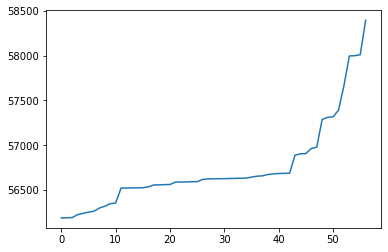

In [8]:
plt.plot(timeline)

In [9]:
obs = standardize(np.array(metadata['RV obs']))
theo = standardize(np.array(metadata['RV theo']))

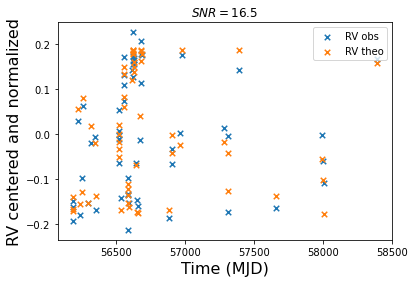

In [10]:
# And see what we made
plt.figure()
plt.scatter(timeline, obs, marker='x', s=30, label='RV obs')
plt.scatter(timeline, theo, marker='x', s=30,label='RV theo')
plt.xlabel('Time (MJD)', fontsize=16)
plt.ylabel('RV centered and normalized', fontsize=16)
plt.legend()
plt.title(r'$SNR='+'{:.1f}'.format(SNR(theo, obs))+'$')
plt.show()

In [11]:
n = len(timeline)
d = 39 # number of orders used

print("Working with n =",n,"time measures and d =",d,"spectral dimensions")

rv = []
sigma = []

for i, raw in metadata.iterrows():
    df = pd.read_csv('data/'+planet+'/SOPHIE.'+raw['File Name']+'_ccf_G2_A.tbl', 
                     sep='\s+', 
                     skiprows=[1,], 
                     index_col='order')
    rv.append(list(df['RV']))
    sigma.append(list(df['sig']))
    
rv = np.array(rv).T
sigma = np.array(sigma).T

assert rv.shape == (d, n)

Working with n = 57 time measures and d = 39 spectral dimensions


The SOPHIE listings contain a lot of informataion on the observations of a given target. Let's take a look at the available columns.

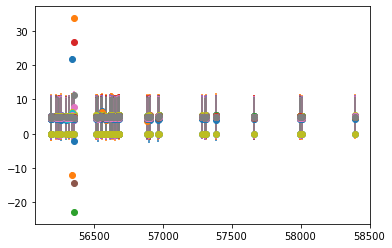

In [12]:
for order in range(d):
    plt.errorbar(timeline, rv[order,:], sigma[order,:], fmt='o')

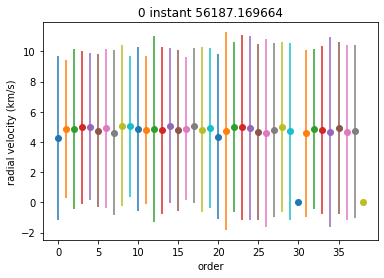

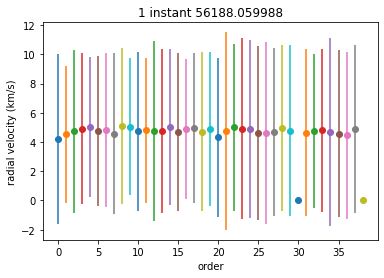

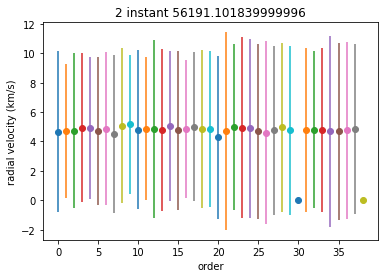

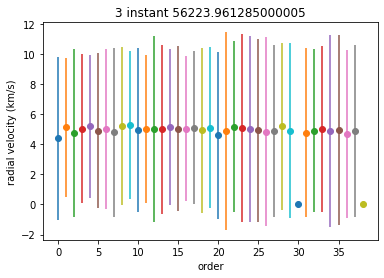

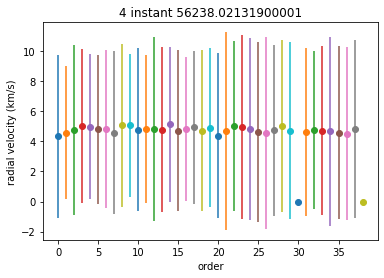

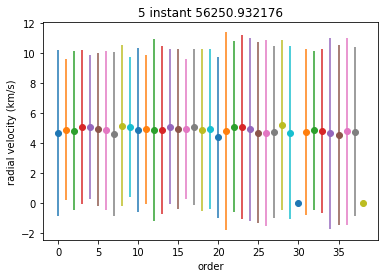

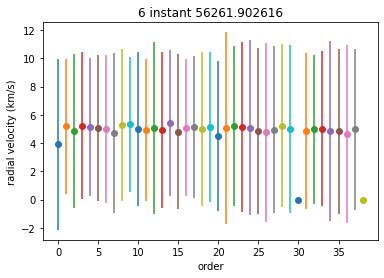

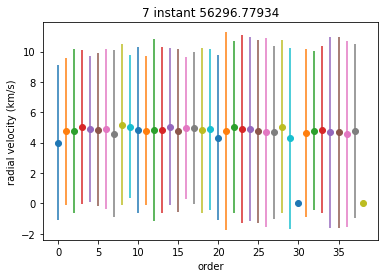

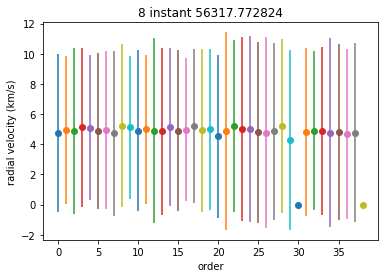

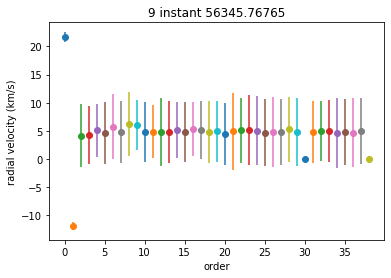

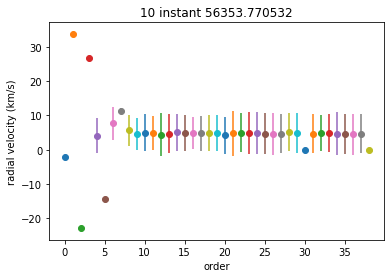

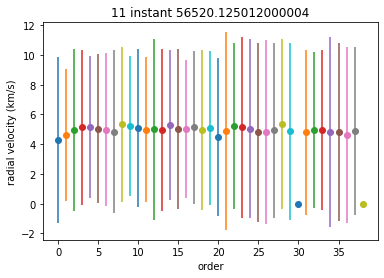

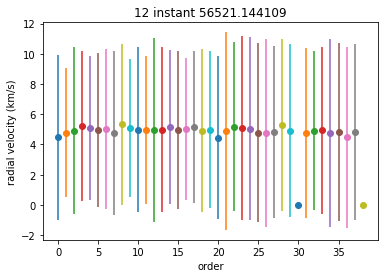

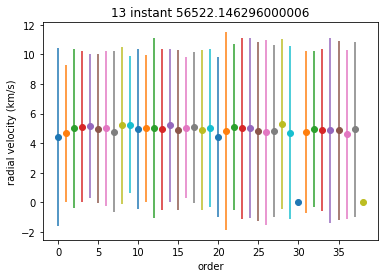

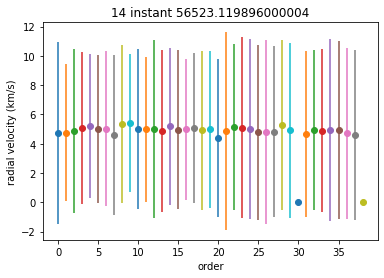

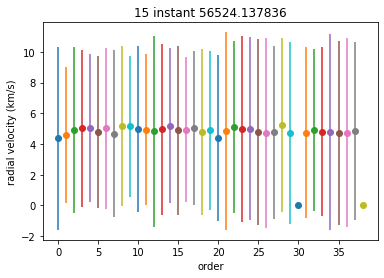

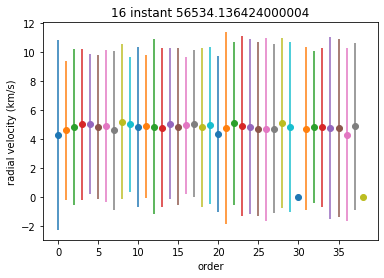

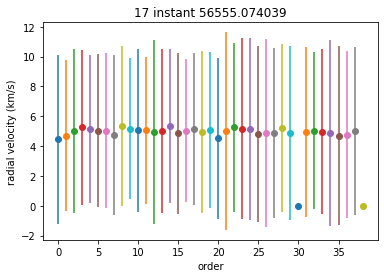

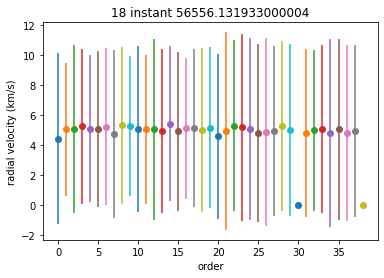

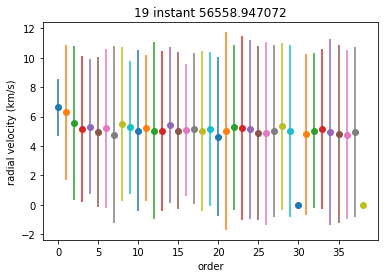

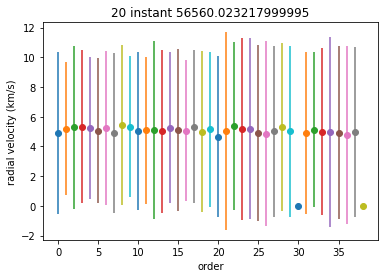

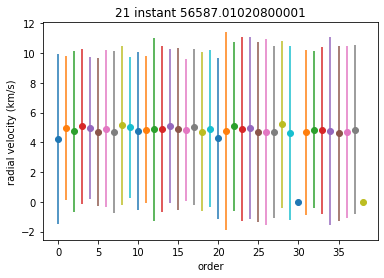

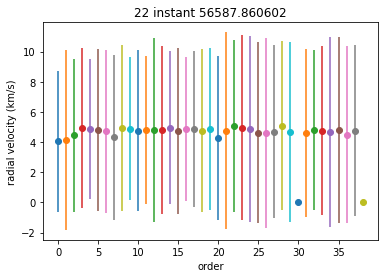

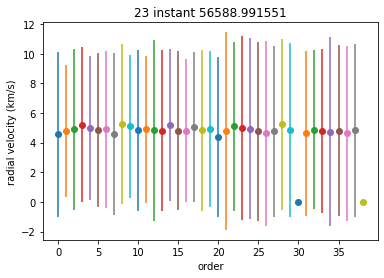

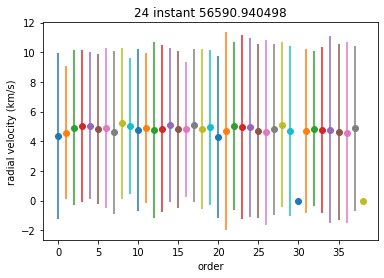

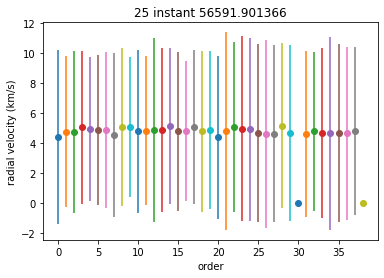

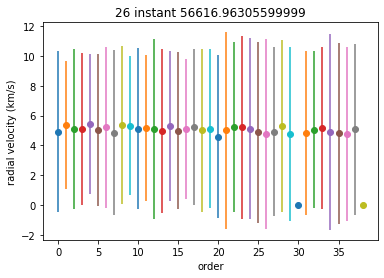

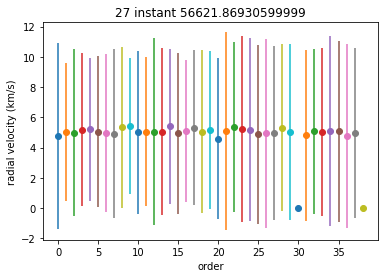

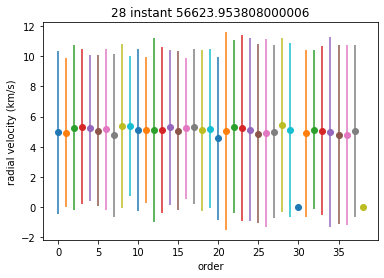

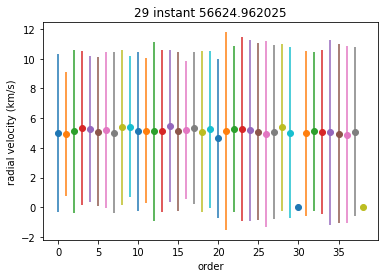

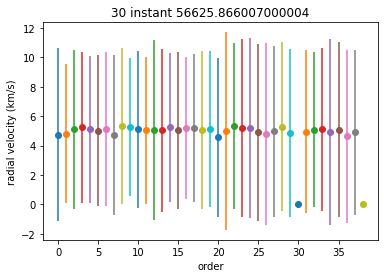

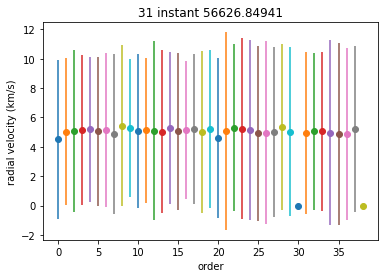

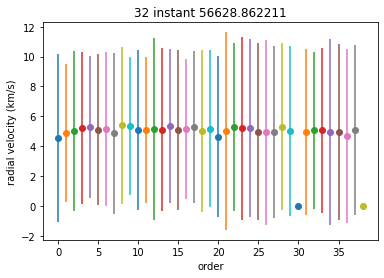

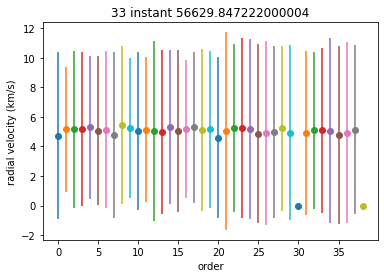

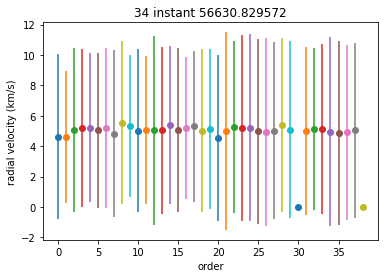

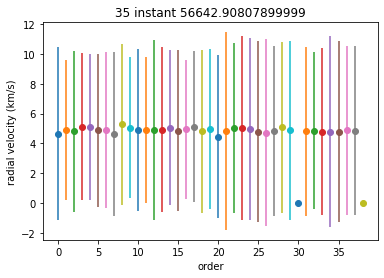

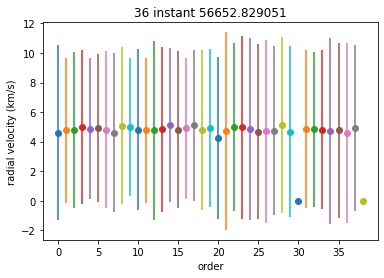

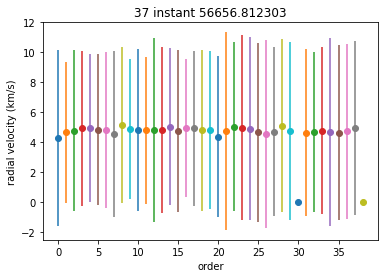

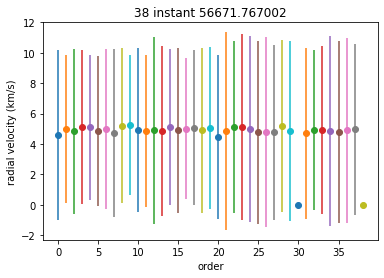

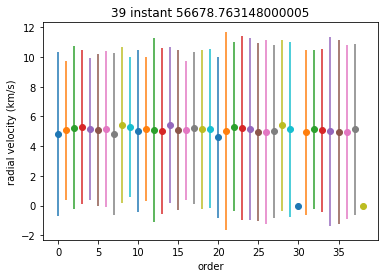

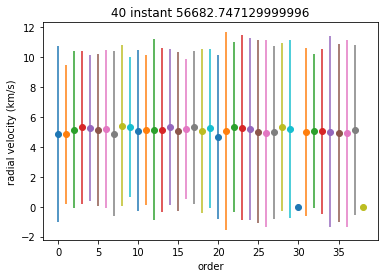

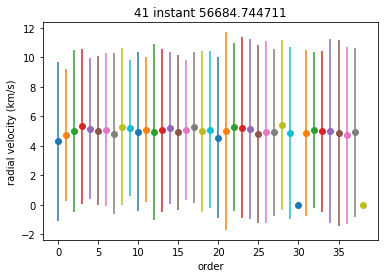

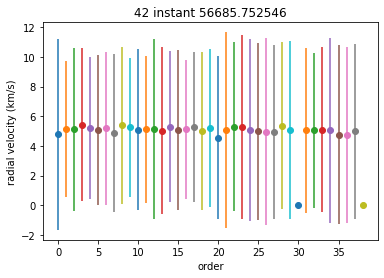

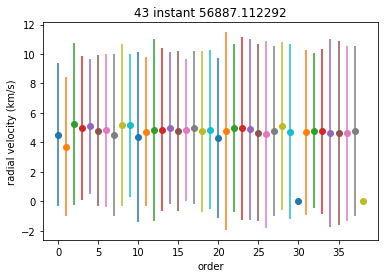

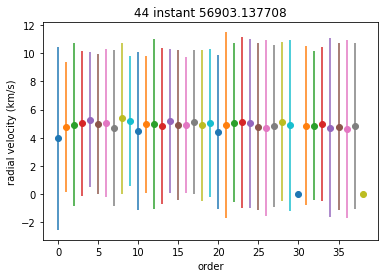

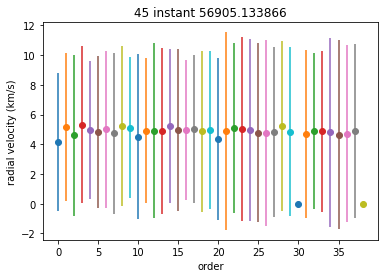

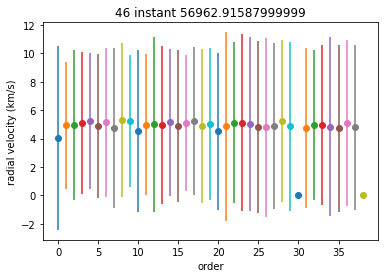

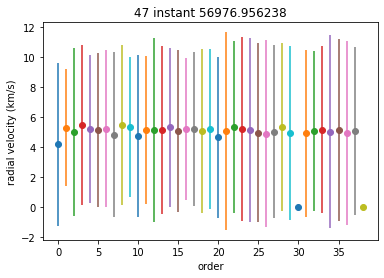

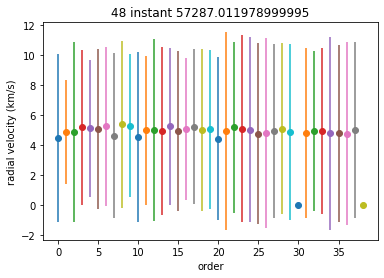

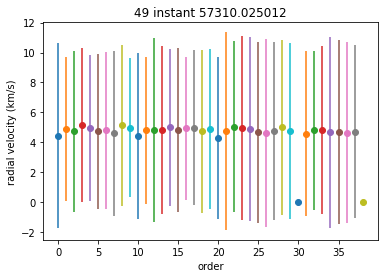

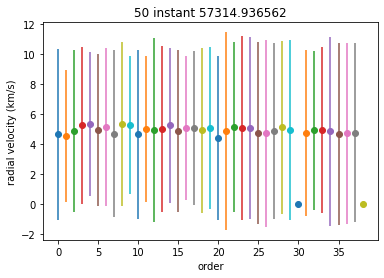

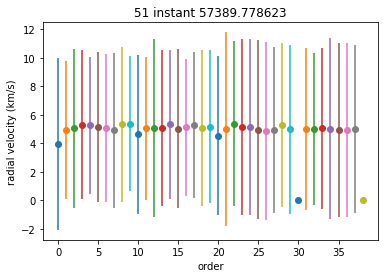

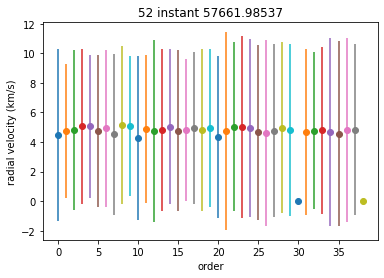

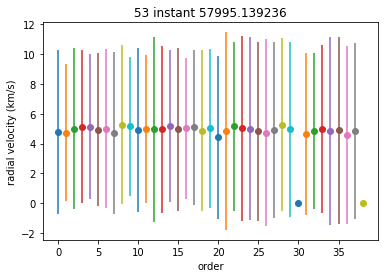

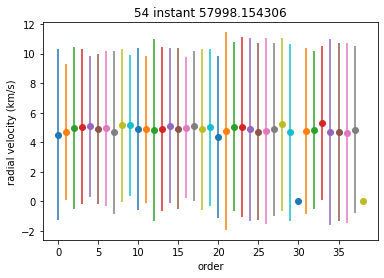

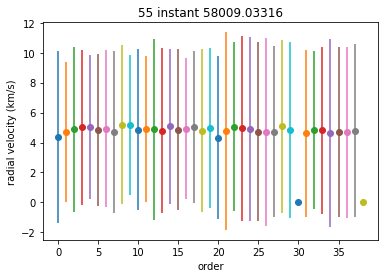

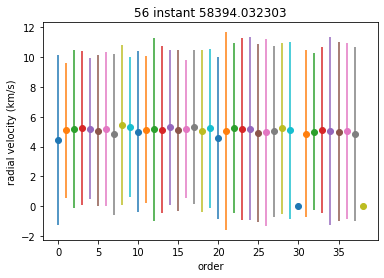

In [13]:
for instant in range(n):
    plt.figure()
    for order in range(d):
        
        plt.title(str(instant)+' instant '+str(timeline[instant]))
        plt.xlabel('order')
        plt.ylabel('radial velocity (km/s)')
        plt.errorbar(order, rv[order, instant], sigma[order, instant], fmt='o')
    plt.show()

We can see that order n°30 and n°38 gives wrong data, so we will delete them in the following.

<ErrorbarContainer object of 3 artists>

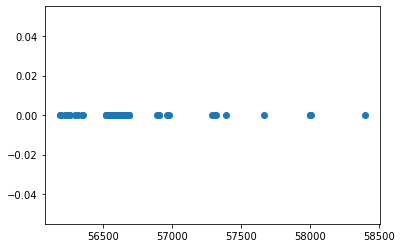

In [14]:
plt.errorbar(timeline, rv[30,:], sigma[30,:], fmt='o')

<ErrorbarContainer object of 3 artists>

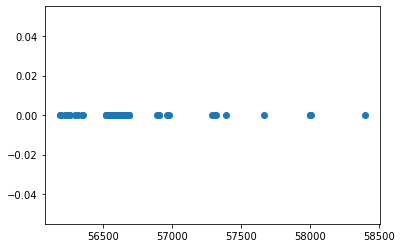

In [15]:
plt.errorbar(timeline, rv[38,:], sigma[38,:], fmt='o')

In [16]:
rv = np.delete(rv, [30, 38], 0)
sigma = np.delete(sigma, [30, 38], 0)

In [17]:
d, n = rv.shape
print("Working with n =",n,"time measures and d =",d,"spectral dimensions")

Working with n = 57 time measures and d = 37 spectral dimensions


In [18]:
ind = np.ones(len(timeline), dtype=bool)
ind[9] = False
ind[10] = False
ind[19] = False

In [19]:
# Select times in the big set
#ind *= (timeline > 56490) & (timeline < 56610)
t = timeline[ind]

print('There are {} points in the big set.'.format(sum(ind)))

There are 54 points in the big set.


In [20]:
rv = rv[:,ind]
sigma = sigma[:,ind]

d, n = rv.shape
print("Working with n =",n,"time measures and d =",d,"spectral dimensions")

Working with n = 54 time measures and d = 37 spectral dimensions


In [21]:
rv = mean(rv)[0]
print('rv centered')

rv centered


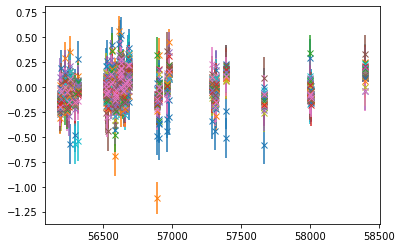

In [22]:
for order in range(d):
    plt.errorbar(t, rv[order,:], sigma[order,:]/30, fmt='x')

# PCA

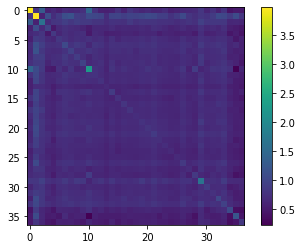

In [23]:
img = plt.imshow(rv.dot(rv.T))
plt.colorbar(img)

In [24]:
rv_w, Whiten_mat, Whiten_mat_inv, eigs_RY_2 = whiten(rv)

In [25]:
eigs_RY_2 /= np.sum(eigs_RY_2)

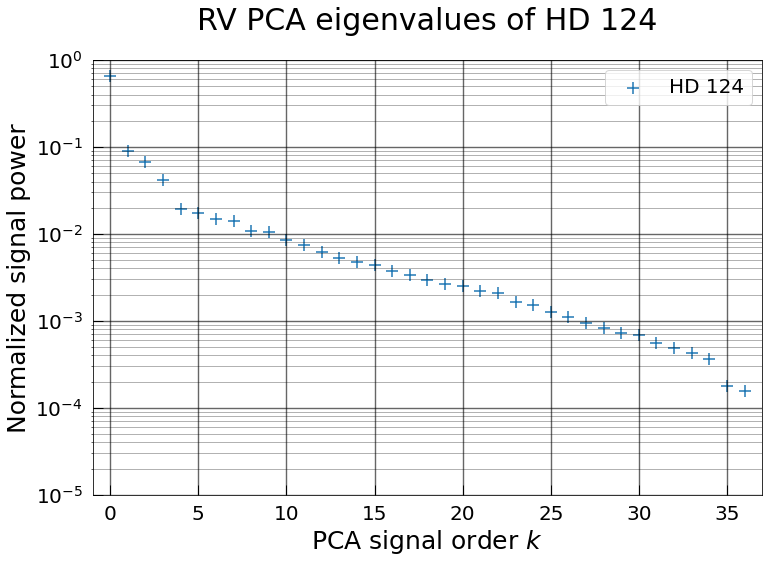

In [26]:
plt.figure(figsize=(12,8))
plt.yscale('log')
plt.grid(True, which='minor', linewidth=0.5, color='black', alpha=0.6)
plt.grid(True, which='major', linewidth=1.4, color='black', alpha=0.6)
plt.ylim((10**-5, 10**0))
plt.xlim(-1,37)
plt.scatter(range(len(rv_w)), eigs_RY_2, marker='+', s=150, linewidths=1, label='HD 124', alpha=1)
plt.tick_params(length=10, width=1, direction='in', pad=10, labelsize=20)
plt.legend(fontsize=20)
plt.xlabel(r'PCA signal order $k$', fontsize=25)
plt.ylabel(r'Normalized signal power', fontsize=25)
plt.title(r'RV PCA eigenvalues of HD 124', fontsize=30, pad=30)
#plt.savefig('PCA_HD124_eigenvalues.png', dpi=200)
plt.show()

Let us build some proxies for the $RV_{theo}$:
- $AVG$: the averaged radial velocity over all the orders
- $PCA_1$: the main component raised by PCA:
$$PCA_1 = \alpha . RV_w[0,:]$$
$$Cov(PCA_1, RV_{theo}) = Var(RV_{theo}) \iff \alpha . Cov(RV_w[0,:], RV_{theo})=Var(RV_{theo}) \iff \alpha = \frac{Var(RV_{theo})}{Cov(RV_w[0,:], RV_{theo})}$$

In [27]:
obs_avg = np.average(rv, axis=0)
PCA1 = rv_w[0,:]*np.array(metadata['RV theo'])[ind].dot(np.array(metadata['RV theo'])[ind]) \
       * 1 / rv_w[0,:].dot(np.array(metadata['RV theo'])[ind])

Text(0, 0.5, 'RV averaged over orders')

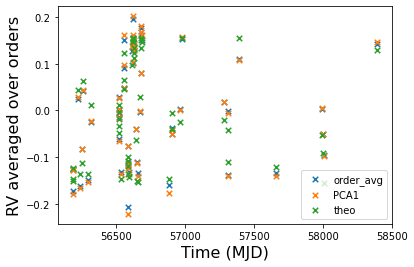

In [28]:
# And plot them
plt.figure()
plt.scatter(t, obs_avg, marker='x', s=30, label='order_avg')
plt.scatter(t, PCA1, marker='x', s=30, label='PCA1')
plt.scatter(t, np.array(metadata['RV theo'])[ind], marker='x', s=30, label='theo')
plt.legend()
plt.xlabel('Time (MJD)', fontsize=16)
plt.ylabel('RV averaged over orders', fontsize=16)

In [29]:
SNR(standardize(theo[ind]), standardize(obs_avg))

13.171817839167106

In [30]:
SNR(standardize(theo[ind]), standardize(PCA1))

12.342355578343746

## Study of the Hope Limit

A simple expression of the upper bound of the best signal candidate that could be found in the output of ICA, when given an input data $X_1, \dots,X_r$ is:

\begin{equation}
\text{HopeLim} (X_1, \dots, X_r) = \sup_{Y \in \text{Vect}(X_1, \dots, X_r)} \text{SNR}(RV_{pl}, Y)
\end{equation}

If we use all the dimensions we have:

In [31]:
sol = minimize(lambda combs: np.sum((combs.dot(rv)-standardize(theo[ind]))**2), np.ones(len(rv)))
print('\nHopeLim =', SNR(standardize(theo[ind]), sol.x.dot(rv)))


HopeLim = 145.7808108563689


We can try to reduce the dimension and look for the variations of HopeLim

In [32]:
def random_dim_reductor(d, d_out):
    red = np.zeros((d_out, d))
    if not (d//d_out)*d_out == d:
        resid = d - (d//d_out)*d_out
        d -= resid
        print('Warning: cropping ', resid,' sources')
    choices = np.random.choice(range(d), (d_out,d//d_out), replace=False)
    for row in range(d_out):
        red[row, choices[row]] = 1
    return red

def avg_dim_reductor(d, d_out):
    red = np.zeros((d_out, d))
    for row in range(d_out):
        red[row, row*(d//d_out):(1+row)*(d//d_out)] = 1
    return red

First let's look at an example when reducting to 6 dimensions using neighbour-grouping:

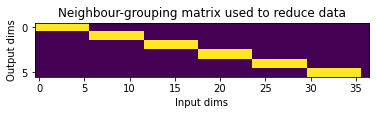

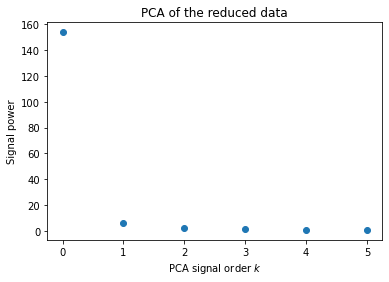


HopeLim = 27.272639698584197
PCA_red1 = 12.44058607245911


In [33]:
d_out = 6
red = avg_dim_reductor(d, d_out)
plt.figure()
plt.title('Neighbour-grouping matrix used to reduce data')
plt.xlabel('Input dims')
plt.ylabel('Output dims')
plt.imshow(red)
plt.show()

rv_w, Whiten_mat, Whiten_mat_inv, eigs_RY_2 = whiten(red.dot(rv))
plt.figure()
plt.title('PCA of the reduced data')
plt.scatter(range(len(rv_w)), eigs_RY_2)
plt.xlabel(r'PCA signal order $k$')
plt.ylabel(r'Signal power')
plt.show()
sol = minimize(lambda combs: np.sum((combs.dot(rv_w)-standardize(theo[ind]))**2), np.ones(len(rv_w)))
print('\nHopeLim =', SNR(standardize(theo[ind]), sol.x.dot(rv_w)))
print('PCA_red1 =', SNR(standardize(theo[ind]), standardize(np.sign(standardize(theo[ind]).dot(rv_w[0,:]))*rv_w[0,:])))

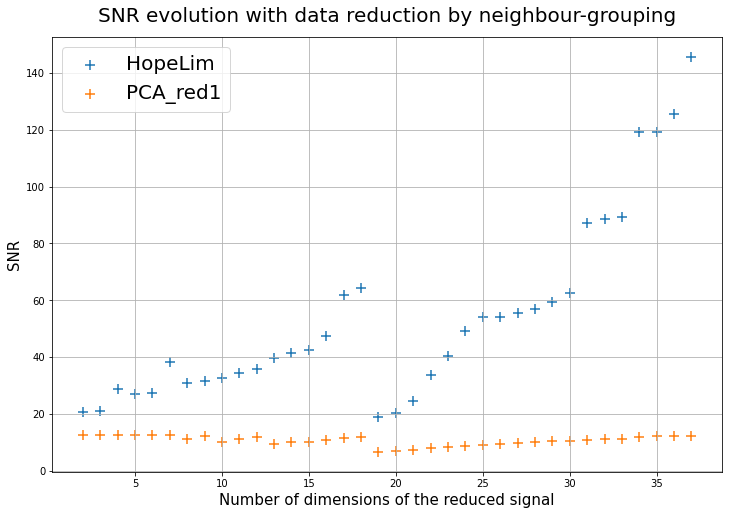

In [34]:
dims = range(2, d+1)
hopes = []
PCAs_red1 = []

for d_out in dims:
    #print("\nReducting to ", d_out, " dims:")
    red = avg_dim_reductor(d, d_out)
    rv_w, Whiten_mat, Whiten_mat_inv, eigs_RY_2 = whiten(red.dot(rv))
    sol = minimize(lambda combs: np.sum((combs.dot(rv_w[:d_out,:])-standardize(theo[ind]))**2), np.ones(len(rv_w[:d_out,:])))
    hope = SNR(standardize(theo[ind]), sol.x.dot(rv_w[:d_out,:]))
    PCA_red1 = SNR(standardize(theo[ind]), standardize(np.sign(standardize(theo[ind]).dot(rv_w[0,:]))*rv_w[0,:]))
    hopes.append(hope)
    PCAs_red1.append(PCA_red1)
    #print('---- HopeLim =', hope)
    #print('---- PCA_red1 =', PCA_red1)

plt.figure(figsize=(12,8))
plt.scatter(dims, hopes, marker='+', s=100, label='HopeLim')
plt.scatter(dims, PCAs_red1, marker='+', s=100, label='PCA_red1')
plt.legend(fontsize=20)
plt.grid(True)
plt.xlabel('Number of dimensions of the reduced signal', fontsize=15)
plt.ylabel('SNR', fontsize=15)
plt.title('SNR evolution with data reduction by neighbour-grouping', fontsize=20, pad=15)
plt.show()

## Analyze through ICA with only one run

First reduce dimension. Here we choose to target 6 but this is arbitrary and such decisions will be made automatically later when using stochastic ICA.

In [35]:
d_out = 4
red = avg_dim_reductor(d, d_out)
rv_w, Whiten_mat, Whiten_mat_inv, eigs_RY_2 = whiten(red.dot(rv))

In [36]:
customICA = CustomICA(rv_w,
                      noise_fraction=10/100,
                      verbose=False, 
                      constraints=['less-entropy'],
                      schedule=[sk_FastICA],
                      schedule_kwargs=[{'max_iter':1000, 'algorithm':'deflation'}],
                      skip_exception=False)

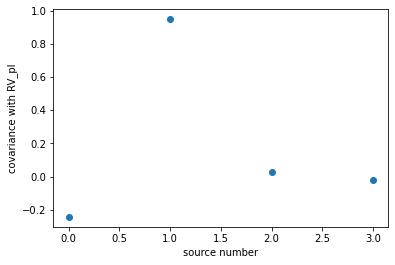


HopeLim = 28.883583065677733
RV_pl identified with source number 1
Resulting SNR = 10.201233047806332


In [63]:
S_hat = customICA.result_traceback[-1]['S']

objective = standardize(theo[ind])
sol = minimize(lambda combs: np.sum((combs.dot(S_hat)-objective)**2), np.ones(len(S_hat)))
plt.figure()
plt.scatter(range(len(sol.x)), sol.x)
plt.xlabel('source number')
plt.ylabel('covariance with RV_pl')
plt.show()
print('\nHopeLim =', SNR(objective, sol.x.dot(S_hat)))
best_ind = np.abs(sol.x).argmax()
print('RV_pl identified with source number', best_ind)
print('Resulting SNR =', SNR(objective, standardize(np.sign(sol.x[best_ind])*S_hat[best_ind])))

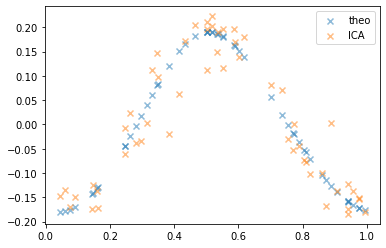

In [65]:
#plt.scatter(t/period % 1, standardize(obs_avg), label='avg', marker='x', alpha=0.5)
#plt.scatter(t/period % 1, standardize(np.sign(standardize(theo[ind]).dot(rv_w[0,:]))*rv_w[0,:]), label='REDPCA1', marker='x', alpha=0.5)
plt.scatter(t/period % 1, standardize(theo[ind]), label='theo', marker='x', alpha=0.5)
plt.scatter(t/period % 1, standardize(np.sign(sol.x[best_ind])*S_hat[best_ind]), label='ICA', marker='x', alpha=0.5)
plt.legend()

## Using stochastic ICA with post-processing

In [100]:
steps = 10

# Specifying the proxy to use:
target = standardize(obs_avg)

# Specify the range of dimensions to explore
target_source_num = list(range(2,8))

In [101]:
#%%capture
def ICA_try(l):
    print('Computing with neighbour-grouping in ',l, ' dimensions...')
    try:
        return CustomICA(whiten(mean(avg_dim_reductor(d, l).dot(rv))[0])[0],
                         noise_fraction=10/100,
                         verbose=False, 
                         constraints=['less-entropy'],
                         num_sources=l,
                         schedule=steps*[sk_FastICA],
                         schedule_kwargs=steps*[{'max_iter':1000, 'algorithm':'deflation'}],
                         skip_exception=False)
    except Exception as error:
        print(error)
        pass
    
ICA_trys = [ICA_try(l) for l in target_source_num]

Computing with neighbour-grouping in  2  dimensions...
Computing with neighbour-grouping in  3  dimensions...
Computing with neighbour-grouping in  4  dimensions...
Computing with neighbour-grouping in  5  dimensions...
Computing with neighbour-grouping in  6  dimensions...


In [102]:
for l in range(5):
    ICA_trys += [ICA_try(l) for l in target_source_num]

Computing with neighbour-grouping in  2  dimensions...
Computing with neighbour-grouping in  3  dimensions...
Computing with neighbour-grouping in  4  dimensions...
Computing with neighbour-grouping in  5  dimensions...
Computing with neighbour-grouping in  6  dimensions...
Computing with neighbour-grouping in  2  dimensions...
Computing with neighbour-grouping in  3  dimensions...
Computing with neighbour-grouping in  4  dimensions...
Computing with neighbour-grouping in  5  dimensions...
Computing with neighbour-grouping in  6  dimensions...
Computing with neighbour-grouping in  2  dimensions...
Computing with neighbour-grouping in  3  dimensions...
Computing with neighbour-grouping in  4  dimensions...
Computing with neighbour-grouping in  5  dimensions...
Computing with neighbour-grouping in  6  dimensions...
Computing with neighbour-grouping in  2  dimensions...
Computing with neighbour-grouping in  3  dimensions...
Computing with neighbour-grouping in  4  dimensions...
Computing 

In [103]:
postProcess = PostProcess(ICA_trys, target)

In [104]:
def threshold_grading(target_corr, entropy):
    '''A way to grade an ICA run only using the correlation between the identified source and the proxy'''
    if abs(target_corr)<0.93:
        return 0
    else:
        return 1

Guess out of 2 sources, epoch=300 relative error:  4.923157723259976 %  SNR:  20.31216662580999
Guess out of 3 sources, epoch=300 relative error:  5.478234237496005 %  SNR:  18.254056994413595
Guess out of 4 sources, epoch=300 relative error:  3.9983837293176547 %  SNR:  25.010105775181696
Guess out of 5 sources, epoch=300 relative error:  5.922361850709317 %  SNR:  16.88515536888768
Guess out of 6 sources, epoch=300 relative error:  5.157854177397141 %  SNR:  19.387907560128813
Guess full, epoch=300 relative error:  3.704681973214806 %  SNR:  26.99287029845186
Guess best, epoch= 300  cov= 0.9843144417417936  entropy= 0.1372702716020748  relative error:  4.923701133137054 %  SNR:  20.30992485043191
Target relative error:  7.591966516773763 %  SNR:  13.171817839167106


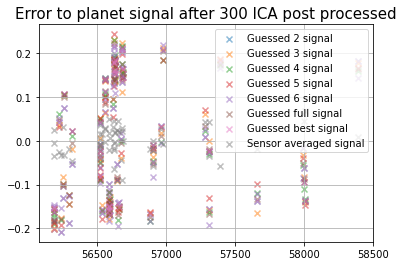

In [105]:
fig = postProcess.investigate(standardize(theo[ind]),
                              plot_timeline=t, plot_title='planet',
                              amplifier=threshold_grading)

In [106]:
ICA_res = postProcess.post_process(amplifier=threshold_grading)
ICA_res *= np.array(metadata['RV theo'])[ind].dot(np.array(metadata['RV theo'])[ind]) \
           * 1 / np.array(metadata['RV theo'])[ind].dot(ICA_res)

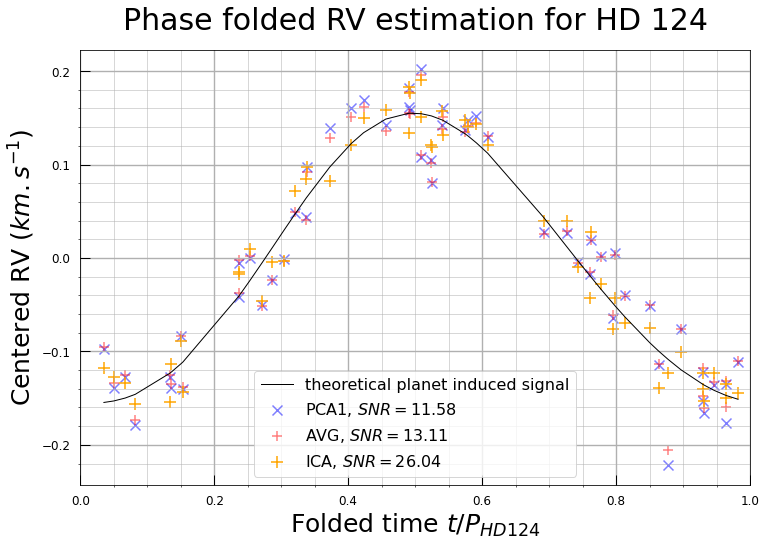

In [107]:
alpha = 0.5
phase = -0.01
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_yticks(np.linspace(-.22,.2,22), minor=True)
ax.set_xticks(np.linspace(0,1,21), minor=True)
plt.grid(True, which='minor', linewidth=0.5)
plt.grid(True, which='major', linewidth=1.4)
plt.xlim(0,1)
plt.tick_params(length=10, width=1, direction='in', pad=10, labelsize='large')
inds = np.argsort((t/period + phase) % 1)
plt.plot(((t/period + phase)% 1 )[inds], np.array(metadata['RV theo'])[ind][inds], linewidth=1, color='black', label=r'theoretical planet induced signal')
plt.scatter((t/period + phase)%1, PCA1, s=100, color='blue', marker='x', alpha=alpha,\
            label=r'PCA1, $SNR={:.2f}$'.format(SNR(np.array(metadata['RV theo'])[ind], PCA1)))
plt.scatter((t/period + phase)%1, obs_avg, s=100, color='red', marker='+', alpha=alpha, \
            label=r'AVG, $SNR={:.2f}$'.format(SNR(np.array(metadata['RV theo'])[ind], obs_avg)))
plt.scatter((t/period + phase)%1, ICA_res, s=150, color='orange', marker='+', alpha=1, \
            label=r'ICA, $SNR={:.2f}$'.format(SNR(np.array(metadata['RV theo'])[ind], ICA_res)))
#plt.errorbar(t/period % 1, obs_avg, 10**-1*np.average(sigma, axis=0)/sigma.shape[0]**.5, fmt='o')
plt.ylabel(r'Centered RV $(km.s^{-1})$', fontsize=25)
plt.legend(fontsize=16)
plt.xlabel(r'Folded time $t/P_{HD124}$', fontsize=25)
plt.title(r'Phase folded RV estimation for HD 124', fontsize=30, pad=20)
#plt.savefig('HD124_phase_fold.png', dpi=200)
plt.show()

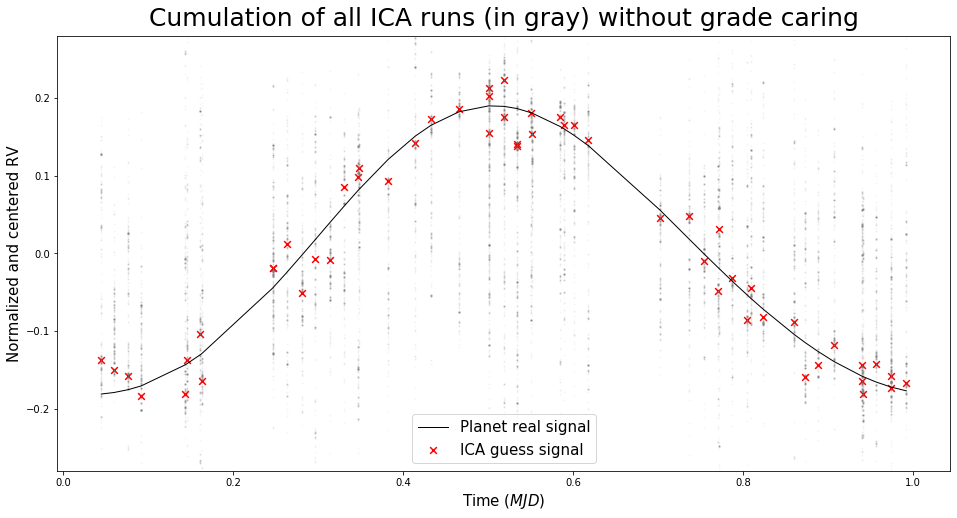

In [64]:
plt.figure(figsize=(16,8))
inds = np.argsort(t/period % 1)
plt.plot((t/period % 1)[inds], standardize(theo[ind])[inds], linewidth=1, color='black', label='Planet real signal')
plt.scatter(t/period % 1, postProcess.post_process(threshold_grading), s=45, color='red', marker='x', label='ICA guess signal')
for l in postProcess.num_sources_list:
    for signal, grade in zip(postProcess.signals[l], postProcess.grades[l]):
        plt.scatter(t/period % 1, signal, s=1, color='gray', alpha=0.05)
#plt.scatter(t/period % 1, postProcess.target, s=45, color='blue', marker='x', label='RV avareged over sensors')
plt.legend(fontsize=15, loc='lower center')
plt.title('Cumulation of all ICA runs (in gray) without grade caring', fontsize=25, pad=10)
plt.xlabel(r'Time $(MJD)$', fontsize=15)
plt.ylabel(r'Normalized and centered RV', fontsize=15)
plt.ylim((-0.28,0.28))
#plt.savefig('results/cumaltion_ICA_basic.png', dpi=200, bbox_inches='tight')
plt.show()

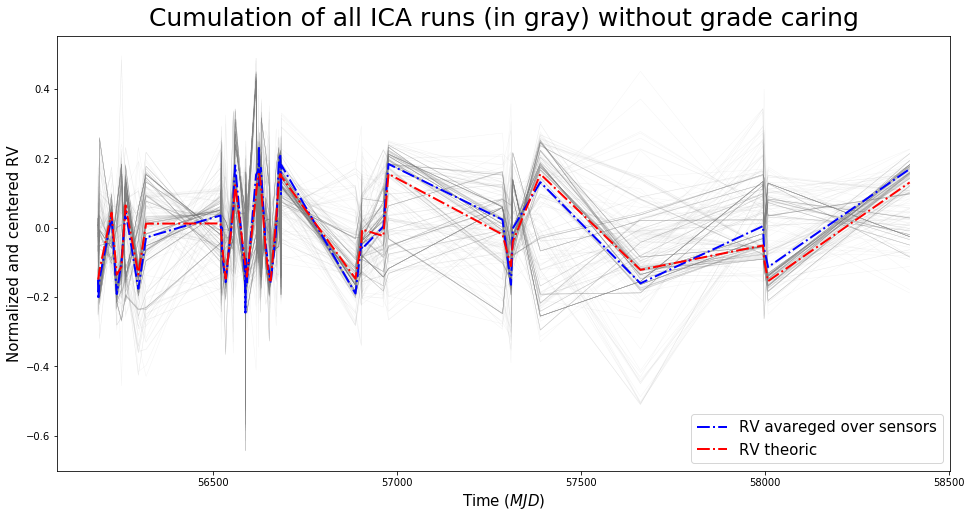

In [65]:
plt.figure(figsize=(16,8))
for l in postProcess.num_sources_list:
    plt.plot(t, postProcess.signals[l].T, linewidth=0.4, color='gray', alpha=0.1)
plt.plot(t, postProcess.target, linestyle='-.', linewidth=2, color='blue', label='RV avareged over sensors')
plt.plot(t, metadata['RV theo'][ind], linestyle='-.', linewidth=2, color='red', label='RV theoric')
plt.legend(fontsize=15)
plt.title('Cumulation of all ICA runs (in gray) without grade caring', fontsize=25, pad=10)
plt.xlabel(r'Time $(MJD)$', fontsize=15)
plt.ylabel(r'Normalized and centered RV', fontsize=15)
#plt.savefig('results/cumaltion_ICA_basic.png', dpi=200, bbox_inches='tight')
plt.show()

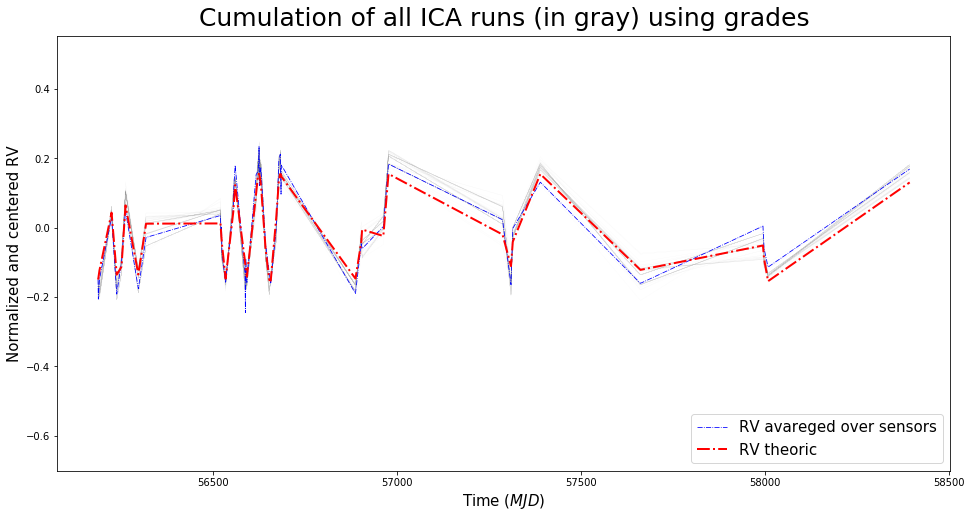

In [66]:
plt.figure(figsize=(16,8))

for l in postProcess.num_sources_list:
    for signal, grade in zip(postProcess.signals[l], postProcess.grades[l]):
        plt.plot(t, signal, linewidth=2*np.tanh(0.01*grade), color='gray', alpha=0.5)
plt.plot(t, postProcess.target, linestyle='-.', linewidth=0.8, color='blue', label='RV avareged over sensors')
plt.plot(t, metadata['RV theo'][ind], linestyle='-.', linewidth=2, color='red', label='RV theoric')
plt.legend(fontsize=15)
plt.title('Cumulation of all ICA runs (in gray) using grades', fontsize=25, pad=10)
plt.xlabel(r'Time $(MJD)$', fontsize=15)
plt.ylabel(r'Normalized and centered RV', fontsize=15)
#plt.savefig('results/cumaltion_ICA_grades.png', dpi=200, bbox_inches='tight')
plt.show()

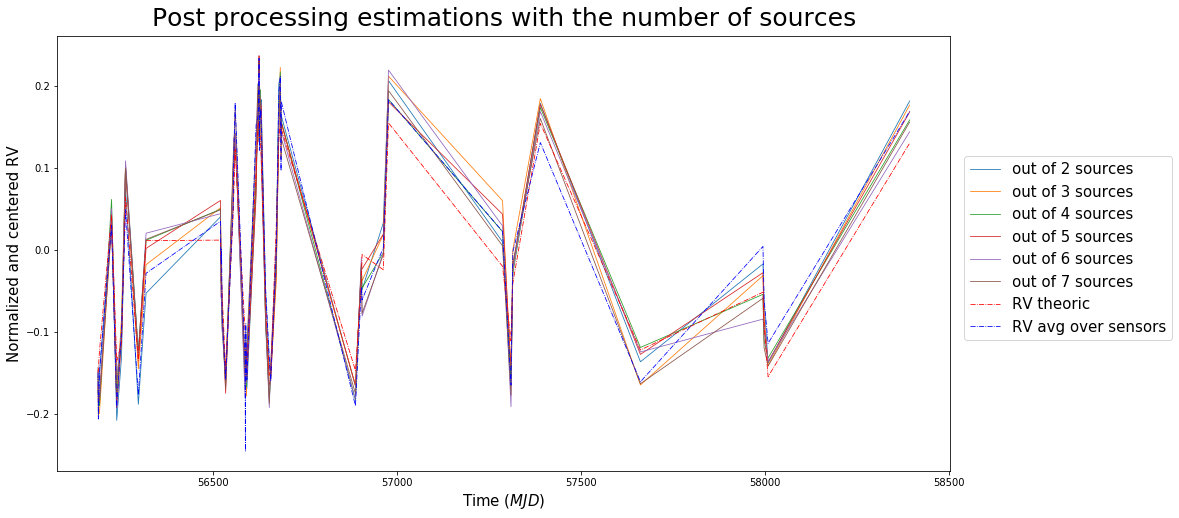

In [67]:
plt.figure(figsize=(16,8))
for l in postProcess.num_sources_list:
    guess = postProcess.post_process(amplifier=threshold_grading, select_l=l)
    plt.plot(t, guess, linestyle='-', linewidth=0.8, label='out of '+str(l)+' sources')
plt.plot(t, metadata['RV theo'][ind], linestyle='-.', linewidth=0.8, color='red', label='RV theoric')    
plt.plot(t, postProcess.target, linestyle='-.', linewidth=0.8, color='blue', label='RV avg over sensors')
plt.legend(fontsize=15, ncol=1, loc=(1.015,0.3))
plt.title('Post processing estimations with the number of sources', fontsize=25, pad=10)
plt.xlabel(r'Time $(MJD)$', fontsize=15)
plt.ylabel(r'Normalized and centered RV', fontsize=15)
#plt.savefig('results/postprocessing_ICA_various.png', dpi=200, bbox_inches='tight')
plt.show()

In [68]:
def fit_to_sinus(timeline, guess, P=period, steps=1000, name=None):
    phi = np.linspace(0,2*np.pi, steps)
    preds = np.sin(2*np.pi*np.stack(steps*(timeline,), -1)/P + np.stack(len(timeline)*(phi,), 0))
    preds /= np.diag(preds.T.dot(preds))**.5
    
    diffs = np.average((np.stack(steps*(guess,),-1) - preds)**2, axis=0)
    ind = diffs.argmin()
    phi_opt = phi[ind]
    preds = preds[:,ind]
    
    smooth_times = np.linspace(timeline[0], timeline[-1], steps)
    smooth_preds = np.sin(2*np.pi*smooth_times/P + phi_opt)
    smooth_preds /= (len(timeline)/steps*smooth_preds.dot(smooth_preds.T))**.5
    
    err = np.average((guess-preds)**2)/np.average(preds**2)
    fig = plt.figure(figsize=(12,6))
    plt.scatter(timeline, guess, marker='x', color='red')
    plt.plot(smooth_times, smooth_preds, color='gray')
    plt.title(name+' error to sinus model: {:.3f}%'.format(100*err), fontsize=20, pad=10)
    plt.xlabel(r'Time $(MJD)$', fontsize=15)
    plt.ylabel(r'Normalized and centered RV', fontsize=15)
    plt.show()
    
    return preds, smooth_times, smooth_preds

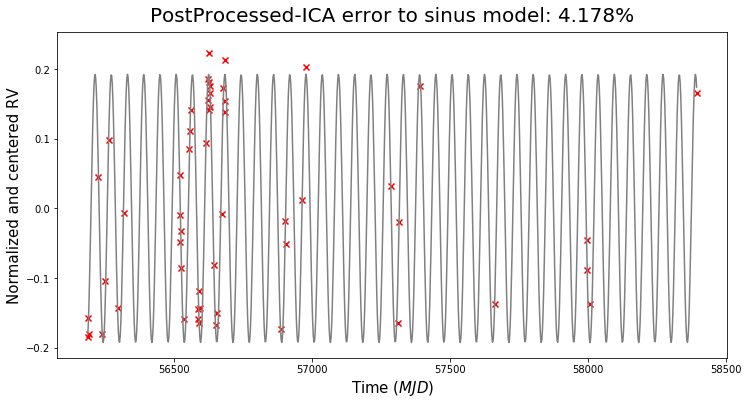

In [69]:
preds, smooth_times, smooth_preds = fit_to_sinus(t, 
                                                 postProcess.post_process(amplifier=threshold_grading),
                                                 name='PostProcessed-ICA')

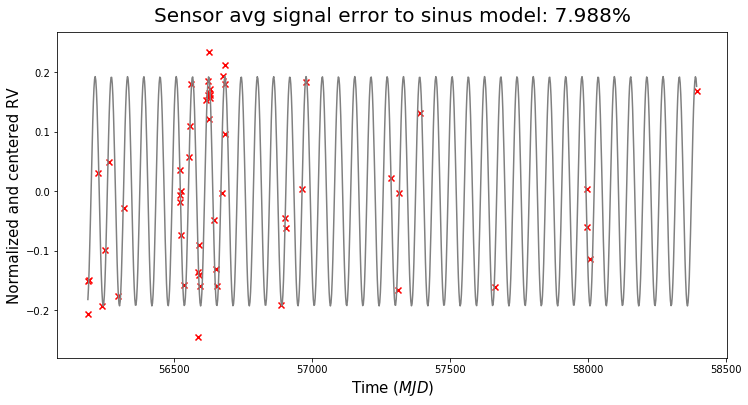

In [70]:
preds, smooth_times, smooth_preds = fit_to_sinus(t, 
                                                 postProcess.target,
                                                 name='Sensor avg signal')

## \<center\>Questions left
    - How to compute covariance/independence of a time series that is not stationnary?
    - How to derive and what can be said about the stellar activity when doing stochastic ICA?
    - Is the number of time points affecting the SNR estimation?